In [1]:
import numpy as np
import pandas as pd
import os
import seaborn as sns
import matplotlib.pyplot
import sklearn.linear_model
import matplotlib.pyplot as plt
import pyreadstat
import datetime
import FG_Methods_1
import tabulate
import seaborn as sns

import warnings

warnings.filterwarnings("ignore")

In [2]:
# Initialise Values

df_path = "C:\\Users\\fabio\\OneDrive\\Documents\\Studies\\Social_Research\\data\\ZA7780_v1-0-0.dta"
df = pd.read_stata(df_path, convert_categoricals=False)
df.info()

unique_country_codes = set(df["isocntry"].values)
unique_country_codes = sorted(unique_country_codes)
print(unique_country_codes)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 38718 entries, 0 to 38717
Columns: 479 entries, studyno1 to w87
dtypes: float64(284), int16(5), int32(3), int8(184), object(3)
memory usage: 92.7+ MB
['AL', 'AT', 'BA', 'BE', 'BG', 'CH', 'CY', 'CY-TCC', 'CZ', 'DE-E', 'DE-W', 'DK', 'EE', 'ES', 'FI', 'FR', 'GB', 'GR', 'HR', 'HU', 'IE', 'IS', 'IT', 'LT', 'LU', 'LV', 'ME', 'MK', 'MT', 'NL', 'NO', 'PL', 'PT', 'RO', 'RS', 'RS-KM', 'SE', 'SI', 'SK', 'TR']


In [3]:
#Output Dataframe as csv

"""project_folder = "C:\\Users\\fabio\\OneDrive\\Documents\\Studies\\Social_Research\\"

df_column_headers = ""
for i in df.columns:
    if i == df.columns[0]:
        df_column_headers = i
    else:
        df_column_headers = df_column_headers + ", " + i

np.savetxt(project_folder + 'social_research_dataframe.csv',  np.asarray(df), header=df_column_headers, delimiter=',', fmt='%s')"""


'project_folder = "C:\\Users\\fabio\\OneDrive\\Documents\\Studies\\Social_Research\\"\n\ndf_column_headers = ""\nfor i in df.columns:\n    if i == df.columns[0]:\n        df_column_headers = i\n    else:\n        df_column_headers = df_column_headers + ", " + i\n\nnp.savetxt(project_folder + \'social_research_dataframe.csv\',  np.asarray(df), header=df_column_headers, delimiter=\',\', fmt=\'%s\')'

In [19]:
def return_stats_on_group(df, column_names, conditions, remap_dict):
    df_filtered = df
    collected_values, collected_means = [], []
    
    for col, condition in conditions.items():
        df_filtered = df_filtered[df_filtered[col]==condition]
    for target_value in column_names:
        
        if not remap_dict == None:
            df_remapped = remap_vector(df_filtered[target_value], remap_dict)
        else:
            df_remapped = df_filtered[target_value]
            
        collected_means  = np.append(collected_means, df_remapped.mean())
        collected_values = np.append(collected_values, df_remapped)
    
    output_mean, output_std = collected_means.mean(), np.nanstd(np.array(collected_values).std())
    output_mean, output_std = float("{:.2f}".format(output_mean)), float("{:.2f}".format(output_std))
    
    return output_mean, output_std

def run_study(unit_group_request_list, unit_group_column, unit_group_name, data_request_list):
    df_results = pd.DataFrame()
    
    for unit_request in unit_group_request_list:
        unit_request_2 = {unit_group_column: v for v in unit_request["unit_group"]}
        
        for data_request in data_request_list:
            remap_dict = data_request["remap_dict"]
            output_mean, output_std = return_stats_on_group(df, data_request['data_group'], unit_request_2, remap_dict)
            
            #enter data to series - FG_note: this likely still clunkly, I'm not sure why I'm using all these dictionaries
            result_dict = {(data_request["data_group_name"], "mean"): output_mean, (data_request["data_group_name"], "std"): output_std}
            result_series = pd.Series(result_dict, name=unit_request["unit_name"])
            df_results = df_results.append(result_series)
    
    df_results[unit_group_name] = df_results.index
    df_results = df_results.groupby(unit_group_name).mean()
    return df_results


def remap_vector(stats_vector, remap_dict):
    unwrap = False
    original_values = []
    new_values = []
    if not isinstance(stats_vector, list):
        original_values = stats_vector.values.tolist()
        unwrap = True
    else:
        original_values = stats_vector
        
    for i in original_values:
        new_values = new_values + [remap_dict[original_values[i]]] 
        
    if unwrap == True:
        output = np.array(new_values)
    else:
        output = new_values
    
    return output

    
    
    

In [13]:
print(datetime.datetime.now())
remap_1 = {1:4, 2:3, 3:2, 4:1, 5:None}
test_output = remap_vector(df["qa1a_2"], remap_1)
print(str(df["qa1a_2"].size))
print(datetime.datetime.now())

type(test_output)


2022-04-26 16:55:10.382550
38718
2022-04-26 16:55:12.516836


numpy.ndarray

In [21]:
# REmapping for Qa1a, below are the original values
# VeryGood-1, RatherG-2, RBad-3, VB-4, I believe 5 is the NA value, as it has a pick rate of c. 1% and the survey NA value of 999 is not present
remap_1 = {1:4, 2:3, 3:2, 4:1, 5:None}

# REmapping for Qa2a
# Better-1, Worse-2, Same-3, I believe 4 is the NA value, as it has a pick rate of c. 1% and the survey NA value of 999 is not present
remap_2 = {1:4, 2:1, 3:2.5, 4:None}

unit_group_request_list = [{"unit_group" : ["GB"], "unit_name": "GB"}, 
                           {"unit_group" : ["IT"], "unit_name": "Italy"}]
unit_group_column = "isocntry"
unit_group_name = "country"
data_request_list = [{"data_group": ["qa1a_1", "qa1a_2", "qa1a_3", "qa1a_4", "qa1a_5", "qa1a_6", "qa1a_7"], "data_group_name": "qa1a", "remap_dict": remap_1},
                     {"data_group": ["qa2a_1", "qa2a_2", "qa2a_3", "qa2a_4", "qa2a_5", "qa2a_6", "qa2a_7"], "data_group_name": "qa2a", "remap_dict": remap_2}]

test_list = ["a","b"]
test_dict = {"a":1, "b":2}

print(datetime.datetime.now())
#return_stats_on_group(df, ["qa1a_2"], {"isocntry":"LT"})
df_results = run_study(unit_group_request_list, unit_group_column, unit_group_name, data_request_list)
print(df_results)
print(datetime.datetime.now())

2022-04-26 16:58:29.332916


In [19]:
print(df[["qa2a_1", "qa2a_2", "qa2a_3", "qa2a_4", "qa2a_5", "qa2a_6", "qa2a_7"]].max())
print(df[["qa2a_1", "qa2a_2", "qa2a_3", "qa2a_4", "qa2a_5", "qa2a_6", "qa2a_7"]].min())
print(df[df["qa2a_1"]==4].count())
print(df["qa2a_1"].count())
    
    
    


qa2a_1    4
qa2a_2    4
qa2a_3    4
qa2a_4    4
qa2a_5    4
qa2a_6    4
qa2a_7    4
dtype: int8
qa2a_1    1
qa2a_2    1
qa2a_3    1
qa2a_4    1
qa2a_5    1
qa2a_6    1
qa2a_7    1
dtype: int8
studyno1    506
studyno2    506
doi         506
version     506
edition     506
           ... 
w100         63
w97          32
w22         383
w92         506
w87         385
Length: 479, dtype: int64
38718


0.0011013507431178252


'"Links on heatmapping and seaborn pairplot to impliment in these methods:\nhttps://seaborn.pydata.org/generated/seaborn.heatmap.html\n\n\n\n'

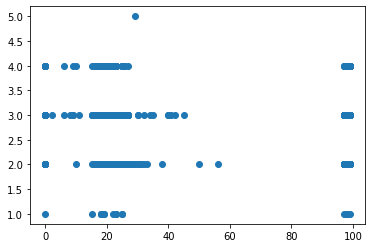

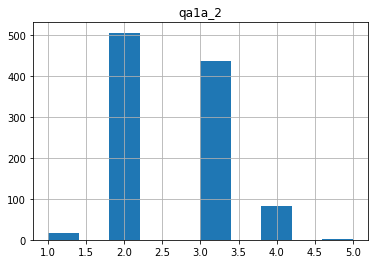

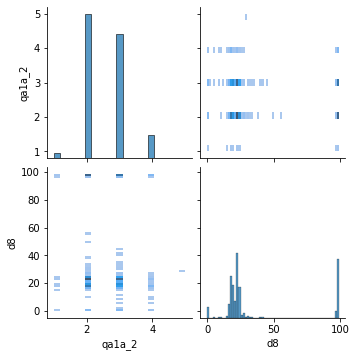

In [10]:
df_1 = df[["isocntry","qa1a_2","d8"]]
df_2 = df_1[df_1['isocntry']=="LT"]
corr_education_econ = df_2["qa1a_2"].corr(df_2["d8"])
print(corr_education_econ)


plt.scatter(df_2["d8"], df_2["qa1a_2"])
df_2.hist("qa1a_2")
sns.pairplot(df_2[['qa1a_2', "d8"]], palette="vlag", kind="hist")

""""Links on heatmapping and seaborn pairplot to impliment in these methods:
https://seaborn.pydata.org/generated/seaborn.heatmap.html



"""
